In [37]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from numpy.random import default_rng
from scipy.optimize import root_scalar
from scipy.interpolate import interp1d
from scipy.stats import norm, chi2
from superrad import ultralight_boson as ub

orig_path= "/Users/sebhoof/Research/BHSR/"

#sys.path.append("../code_matt/")
rng = default_rng()

#from BH_functions import stellar_functions

from py.plotting import *
from py.constants import *
from py.bhsr import *
from py.bosenova import *

yr = 365*24*60*60 # s

!mkdir -p figures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# This is called the "non-relativistic approximation (see Fig. 5 in 1004.3558)"

def c_nl_1004(n, l):
    x = Fraction(factorial(2*l+n+1) * 2**(4*l+2), factorial(n) * (l+n+1)**(2*l+4) )
    y = Fraction(factorial(l), factorial(2*l+1)*factorial(2*l))
    return x*y*y

def c_nl_1004_float(n, l):
    c_nl_fr = c_nl_1004(n, l)
    return 1.0*c_nl_fr

def GammaSR_nlm_1004(ma, mbh, astar, n, l, m):
    al = alpha(ma, mbh)
    marp = al*(1 + np.sqrt(1-astar*astar))
    x = 2.0*(0.5*m*astar - marp)
    factors = [(k*k)*(1.0-astar*astar) + x*x for k in range(1,l+1)]
    return  ma*x * al**(4*(l+1)) * c_nl_1004_float(n, l) * prod(factors)

In [87]:
bc = ub.UltralightBoson(spin=0, model="relativistic")
wf = bc.make_waveform(20.8, 0.7, 1.16e-12, units="physical")
wf.cloud_growth_time()

28885552.841335747

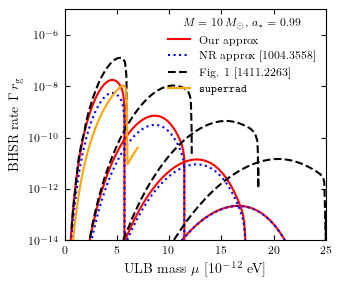

In [95]:
states = [(ell+1, ell, ell) for ell in range(1,6)]

masha_bhsr_rates = []
for i in range(1,5):
    data = np.genfromtxt("data/1411_2263/ell_{:d}".format(i))
    masha_bhsr_rates.append(data)
   
m_bh = 10.0
muvals_small = np.linspace(0.01, 7, 200)*1e-12
muvals = np.linspace(0.01, 25, 250)*1e-12
superrad_bhsr_rates = []
bc = ub.UltralightBoson(spin=0, model="relativistic")
for mu in muvals_small:
    wf = bc.make_waveform(m_bh, 0.99, mu, units="physical")
    gtime = wf.cloud_growth_time()/inv_eVs
    nu = 2.*np.pi/gtime
    M = m_bh*Msol_in_eV 
    GMnu = nu*M/mP_in_eV**2.
    # print("{:.3e}".format(M/mP_in_eV**2.))
    #superrad_bhsr_rates.append(rg(10)*inv_eVs/gtime)
    superrad_bhsr_rates.append(GMnu)

for s in states:
    n, l, m = s
    p0 = plt.plot(muvals/1e-12, GammaSR_nlm_mod(muvals, m_bh, 0.99, n, l, m)*rg(m_bh), 'r', label=r"Our approx")
    p1 = plt.plot(muvals/1e-12, GammaSR_nlm_1004(muvals, m_bh, 0.99, n, l, m)*rg(m_bh), 'b:', label=r"NR approx [1004.3558]")
for d in masha_bhsr_rates:
    p2 = plt.plot(d[:,0]/1e-12, d[:,1], 'k--', label=r"Fig. 1 [1411.2263]")
p3 = plt.plot(muvals_small/1e-12, superrad_bhsr_rates, c='orange', label=r"\texttt{superrad}")
plt.legend(handles=p0+p1+p2+p3, title=r"$M = 10\,M_\odot$, $a_\ast = 0.99$")
plt.xlabel(r"ULB mass $\mu$ [$10^{-12}$ eV]")
plt.ylabel(r"BHSR rate $\Gamma\,r_\text{g}$")
plt.xlim([0, 25])
plt.ylim([1e-14, 1e-5])
plt.yscale('log')
plt.savefig("figures/rate_comparison.pdf", backend='pgf')
plt.show()